# Measuring Quantum Volume

## Introduction

**Quantum Volume (QV)** is a single-number metric that can be measured using a concrete
protocol on near-term quantum computers of modest size. The QV method quantifies
the largest random circuit of equal width and depth that the computer successfully implements.
Quantum computing systems with high-fidelity operations, high connectivity, large calibrated gate
sets, and circuit rewriting toolchains are expected to have higher quantum volumes. 


## The Quantum Volume Protocol

A QV protocol (see [1]) consists of the following steps:

(We should first import the relevant qiskit classes for the demonstration).

In [1]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

#Import Qiskit classes
import qiskit
from qiskit import assemble, transpile
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error

#Import the qv function
import qiskit.ignis.verification.quantum_volume as qv

### Step 1: Generate QV sequences

It is well-known that quantum algorithms can be expressed as polynomial-sized quantum circuits built from two-qubit unitary gates. Therefore, a model circuit consists of $d$ layers of random permutations of the qubit labels, followed by random two-qubit gates (from $SU(4)$). When the circuit width $m$ is odd, one of the qubits is idle in each layer.

More precisely, a **QV circuit** with **depth $d$** and **width $m$**, is a sequence $U = U^{(d)}...U^{(2)}U^{(1)}$ of $d$ layers:


$$ U^{(t)} = U^{(t)}_{\pi_t(m'-1),\pi_t(m)} \otimes ... \otimes U^{(t)}_{\pi_t(1),\pi_t(2)} $$


each labeled by times $t = 1 ... d$ and acting on $m' = 2 \lfloor n/2 \rfloor$ qubits. 
Each layer is specified by choosing a uniformly random permutation $\pi_t \in S_m$ of the $m$ qubit indices
and sampling each $U^{(t)}_{a,b}$, acting on qubits $a$ and $b$, from the Haar measure on $SU(4)$.

In the following example we have 6 qubits Q0,Q1,Q3,Q5,Q7,Q10. We are going to look at subsets up to the full set
(each volume circuit will be depth equal to the number of qubits in the subset)

In [2]:
# qubit_lists: list of list of qubit subsets to generate QV circuits
qubit_lists = [[0,1,3],[0,1,3,5],[0,1,3,5,7],[0,1,3,5,7,10]]
# ntrials: Number of random circuits to create for each subset
ntrials = 100

We generate the quantum volume sequences. We start with a small example (so it doesn't take too long to run).

In [3]:
import warnings
warnings.filterwarnings('ignore')
qv_circs, qv_circs_nomeas = qv.qv_circuits(qubit_lists, ntrials)

As an example, we print the circuit corresponding to the first QV sequence. Note that the ideal circuits are run on the first n qubits (where n is the number of qubits in the subset).

In [4]:
# pass the first trial of the nomeas through the transpiler to illustrate the circuit
qv_circs_nomeas[0] = qiskit.compiler.transpile(qv_circs_nomeas[0], basis_gates=['u1','u2','u3','cx'])

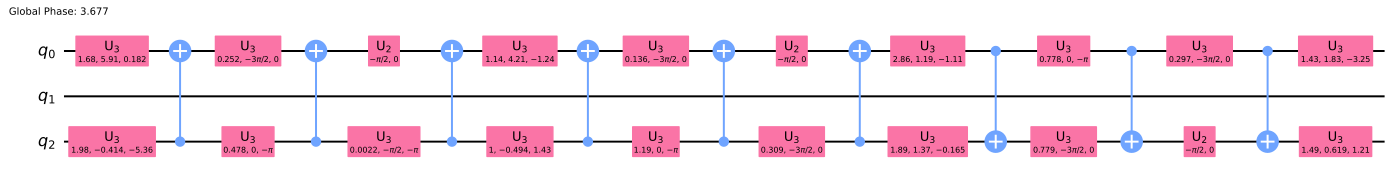

In [5]:
qv_circs_nomeas[0][0].draw(fold=-1)

### Step 2: Simulate the ideal QV circuits

The quantum volume method requires that we know the ideal output for each circuit, so we use the Aer simulator to get the ideal result.

In [7]:
sv_sim = qiskit.Aer.get_backend('aer_simulator')
ideal_results = []
for trial in range(ntrials):
    clear_output(wait=True)
    for qc in qv_circs_nomeas[trial]:
        qc.save_statevector()
    result = qiskit.execute(qv_circs_nomeas[trial], backend=sv_sim).result()
    ideal_results.append(result)
    print(f'Simulated trial {trial+1}/{ntrials}')

Simulated trial 100/100


Next, we load the ideal results into a quantum volume fitter

In [8]:
qv_fitter = qv.QVFitter(qubit_lists=qubit_lists)
qv_fitter.add_statevectors(ideal_results)

### Step 3: Calculate the heavy outputs

To define when a model circuit $U$ has been successfully implemented in practice, we use the *heavy output* generation problem. The ideal output distribution is $p_U(x) = |\langle x|U|0 \rangle|^2$, 
where $x \in \{0,1\}^m$ is an observable bit-string. 

Consider the set of output probabilities given by the range of $p_U(x)$ sorted in ascending order 
$p_0 \leq p_1 \leq \dots \leq p_{2^m-1}$. The median of the set of probabilities is 
$p_{med} = (p_{2^{m-1}} + p_{2^{m-1}-1})/2$, and the *heavy outputs* are


$$ H_U = \{ x \in \{0,1\}^m \text{ such that } p_U(x)>p_{med} \}.$$


The heavy output generation problem is to produce a set of output strings such that more than two-thirds are heavy.

As an illustration, we print the heavy outputs from various depths and their probabilities (for trial 0):

In [9]:
for qubit_list in qubit_lists:
    l = len(qubit_list)
    print ('qv_depth_'+str(l)+'_trial_0:', qv_fitter._heavy_outputs['qv_depth_'+str(l)+'_trial_0'])

qv_depth_3_trial_0: ['000', '001', '010', '100']
qv_depth_4_trial_0: ['0010', '0011', '0100', '0101', '0110', '1001', '1011', '1110']
qv_depth_5_trial_0: ['00010', '00011', '00100', '00101', '00110', '00111', '01011', '01100', '01101', '01110', '01111', '10000', '11001', '11011', '11110', '11111']
qv_depth_6_trial_0: ['000000', '000001', '000011', '000100', '001000', '001010', '001111', '010000', '010010', '010011', '010100', '010110', '011110', '100000', '100010', '100011', '100100', '100110', '101001', '101010', '101111', '110000', '110001', '110010', '110100', '110110', '110111', '111000', '111001', '111011', '111100', '111110']


In [10]:
for qubit_list in qubit_lists:
    l = len(qubit_list)
    print ('qv_depth_'+str(l)+'_trial_0:', qv_fitter._heavy_output_prob_ideal['qv_depth_'+str(l)+'_trial_0'])

qv_depth_3_trial_0: 0.8655813834341206
qv_depth_4_trial_0: 0.8875227654224885
qv_depth_5_trial_0: 0.8543419735543125
qv_depth_6_trial_0: 0.8661188949571332


### Step 4: Define the noise model

We define a noise model for the simulator. To simulate decay, we add depolarizing error probabilities to the CNOT and U gates.

In [11]:
noise_model = NoiseModel()
p1Q = 0.002
p2Q = 0.02
noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
noise_model.add_all_qubit_quantum_error(depolarizing_error(2*p1Q, 1), 'u3')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')

We can execute the QV sequences either using Qiskit Aer Simulator (with some noise model) or using IBMQ provider, and obtain a list of exp_results.

In [12]:
aer_sim = qiskit.Aer.get_backend('aer_simulator')
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
shots = 1024
exp_results = []
for trial in range(ntrials):
    clear_output(wait=True)
    t_qcs = transpile(qv_circs[trial], basis_gates=basis_gates, optimization_level=3)
    qobj = assemble(t_qcs)
    result = aer_sim.run(qobj, noise_model=noise_model, max_parallel_experiments=0).result()
    exp_results.append(result)
    print(f'Completed trial {trial+1}/{ntrials}')

Completed trial 100/100


### Step 5: Calculate the average gate fidelity

The *average gate fidelity* between the $m$-qubit ideal unitaries $U$ and the executed $U'$ is:


$$ F_{avg}(U,U') = \frac{|Tr(U^{\dagger}U')|^2/2^m+1}{2^m+1}$$



The observed distribution for an implementation $U'$ of model circuit $U$ is $q_U(x)$, and the probability of sampling
a heavy output is:


$$ h_U = \sum_{x \in H_U} q_U(x)$$



As an illustration, we print the heavy output counts from various depths (for trial 0):

In [13]:
qv_fitter.add_data(exp_results)
for qubit_list in qubit_lists:
    l = len(qubit_list)
    print ('qv_depth_'+str(l)+'_trial_0:', qv_fitter._heavy_output_counts['qv_depth_'+str(l)+'_trial_0'])

qv_depth_3_trial_0: 828
qv_depth_4_trial_0: 839
qv_depth_5_trial_0: 768
qv_depth_6_trial_0: 694


### Step 6: Calculate the achievable depth

The probability of observing a heavy output by implementing a randomly selected depth $d$ model circuit is:


$$h_d = \int_U h_U dU$$



The *achievable depth* $d(m)$ is the largest $d$ such that we are confident that $h_d > 2/3$. In other words,


$$ h_1,h_2,\dots,h_{d(m)}>2/3 \text{ and } h_{d(m)+1} \leq 2/3$$



We now convert the heavy outputs in the different trials and calculate the mean $h_d$ and the error for plotting the graph.

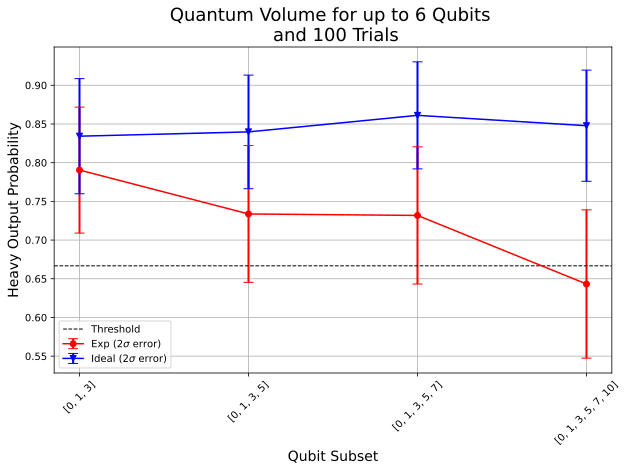

In [14]:
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Plot the essence by calling plot_rb_data
qv_fitter.plot_qv_data(ax=ax, show_plt=False)

# Add title and label
ax.set_title('Quantum Volume for up to %d Qubits \n and %d Trials'%(len(qubit_lists[-1]), ntrials), fontsize=18)

plt.show()

### Step 7: Calculate the Quantum Volume


The quantum volume treats the width and depth of a model circuit with equal importance and measures the largest square-shaped (i.e., $m = d$) model circuit a quantum computer can implement successfully on average. 

The *quantum volume* $V_Q$ is defined as


$$\log_2 V_Q = \arg\max_{m} \min (m, d(m))$$



We list the statistics for each depth. For each depth we list if the depth was successful or not and with what confidence interval. For a depth to be successful the confidence interval must be > 97.5%.

In [15]:
qv_success_list = qv_fitter.qv_success()
qv_list = qv_fitter.ydata
QV = 1
for qidx, qubit_list in enumerate(qubit_lists):
    if qv_list[0][qidx]>2/3:
        if qv_success_list[qidx][0]:
            print("Width/depth %d greater than 2/3 (%f) with confidence %f (successful). Quantum volume %d"%
                  (len(qubit_list),qv_list[0][qidx],qv_success_list[qidx][1],qv_fitter.quantum_volume()[qidx]))
            QV = qv_fitter.quantum_volume()[qidx]
        else:
            print("Width/depth %d greater than 2/3 (%f) with confidence %f (unsuccessful)."%
                  (len(qubit_list),qv_list[0][qidx],qv_success_list[qidx][1]))
    else:
        print("Width/depth %d less than 2/3 (unsuccessful)."%len(qubit_list))

Width/depth 3 greater than 2/3 (0.790439) with confidence 0.998822 (successful). Quantum volume 8
Width/depth 4 greater than 2/3 (0.733740) with confidence 0.935429 (unsuccessful).
Width/depth 5 greater than 2/3 (0.731826) with confidence 0.929333 (unsuccessful).
Width/depth 6 less than 2/3 (unsuccessful).


In [16]:
print ("The Quantum Volume is:", QV) 

The Quantum Volume is: 8


### References

[1] Andrew W. Cross, Lev S. Bishop, Sarah Sheldon, Paul D. Nation, and Jay M. Gambetta, *Validating quantum computers using randomized model circuits*, Phys. Rev. A **100**, 032328 (2019). https://arxiv.org/pdf/1811.12926

In [17]:
import qiskit.tools.jupyter
%qiskit_version_table